# Part 1: Self Organinzing Map

Importing necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Importing Data

In [2]:
dataset = pd.read_csv('/content/Credit_Card_Applications.csv')

Last Column contains whether the application was accepted or not

In [4]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

Feature Scaling

In [5]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler( feature_range=(0,1) )
X = sc.fit_transform(X)

Training the SOM

In [6]:
!pip install MiniSom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for MiniSom: filename=MiniSom-2.3.0-py3-none-any.whl size=9018 sha256=4694b76e51bdca48e72f3b003e7e0513ee04d0099762ca161d87b33ffe26900a
  Stored in directory: /root/.cache/pip/wheels/d4/ca/4a/488772b0399fec45ff53132ed14c948dec4b30deee3a532f80
Successfully built MiniSom


In [7]:
from minisom import MiniSom

MiniSom() Arguments:

x,y : Dimensions of the Final Map

input_len: Number of Columns

sigma: Radius of Neighbothood

learning_rate: Hyperparameter determing the speed of learning

In [8]:
som = MiniSom( x=10, y=10, input_len=15, sigma=1.0, learning_rate=0.5 )

#Initialize the Weights

som.random_weights_init(X)

Training:

Selects a random point, find the closest set of Weights, moves the weights closer along with its neighbors

In [9]:
som.train_random( data=X, num_iteration=100 )

Visualizing the results

In [10]:
from pylab import bone, pcolor, colorbar, plot, show

To get a Window: bone()

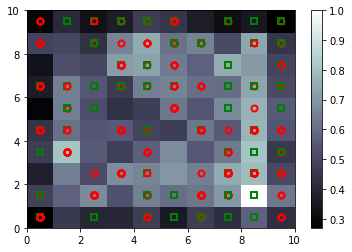

In [15]:
bone()
# som.distance_map().T - Transpose of the Matrix containing Mean Inter-Neuron Distances
pcolor(som.distance_map().T)
#Legends
colorbar()
#Markers 'o'-Circle, 's'-Square
markers = ['o','s']
colors = ['r','g']
#i - Indices, x - Values
for i,x in enumerate(X):
  #To get our Winning Node
  w = som.winner(x)
  #w[0],w[1] coordinates of left corner
  # +0.5 to take it to center
  #y[i] - 0 if No approval, 1 if approved
  plot(w[0] + 0.5,
       w[1] + 0.5,
       markers[y[i]],
       markeredgecolor = colors[y[i]],  #Only Edge is Colored
       markerfacecolor = 'None',        #Face is Transparent
       markersize = 6,                  #Size of Marker
       markeredgewidth = 2 )            #Size of Marker Edge
show()

#Map with Largest MID are outliers => Frauds

Finding the Frauds

In [16]:
#Returns a Dictionary: Associated to each coordinate[KEY] is a List[VALUE] of Customers
mappings = som.win_map(data=X)

In [18]:
frauds = np.concatenate((mappings[(8,1)],mappings[(1,3)]), axis=0)
frauds = sc.inverse_transform(frauds)

In [32]:
indices = []
for i in frauds:
  indices.append(i[0])
indices

[15597536.0,
 15697310.0,
 15571284.0,
 15570947.0,
 15641715.0,
 15592326.0,
 15622507.0,
 15706602.0,
 15728082.0,
 15675176.0,
 15768449.0,
 15665374.0,
 15594305.0,
 15664793.0,
 15670029.0,
 15763579.0,
 15662189.0,
 15568469.0,
 15782159.0,
 15717700.0,
 15646535.0,
 15749964.0]

dataset['CustomerID'].isin(indices) is Vector of Bollean Valaues

In [33]:
f = dataset[ dataset['CustomerID'].isin(indices)]
print(f)

     CustomerID  A1     A2      A3  A4  A5  A6     A7  A8  A9  A10  A11  A12  \
61     15594305   0  23.75   0.710   2   9   4  0.250   0   1    1    1    2   
98     15664793   0  17.33   9.500   2   6   4  1.750   0   1   10    1    2   
106    15597536   1  27.67   2.000   2  14   8  1.000   1   1    4    0    2   
178    15697310   1  41.17   4.040   2  13   8  7.000   1   1    8    0    2   
245    15670029   0  16.92   0.500   2   3   4  0.165   0   1    6    1    2   
246    15763579   0  16.00   0.165   2   6   4  1.000   0   1    2    1    2   
265    15662189   0  28.58   3.750   2   8   4  0.250   0   1    1    1    2   
278    15571284   1  32.83   2.500   2  13   8  2.750   1   1    6    0    2   
304    15568469   0  15.83   7.625   2  11   4  0.125   0   1    1    1    2   
308    15782159   0  22.67   0.750   2   8   4  2.000   0   1    2    1    2   
358    15570947   1  27.25   1.665   2  13   8  5.085   1   1    9    0    2   
373    15717700   0  23.58   0.830   2  

# Part 2: Integrating with ANN

Creating the matrix of features

In [34]:
#We'll omit the CustomerID and add the Approval column
customer = dataset.iloc[:,1:].values

Adding the Dependent Variable

In [41]:
is_fraud = np.zeros(len(dataset))
for i in range(len(dataset)):
  if dataset.iloc[i,0] in indices:  #i-th row, 0th column
    is_fraud[i] = 1
'''
is_fraud = dataset['CustomerID'].isin(indices)
'''

"\nis_fraud = dataset['CustomerID'].isin(indices)\n"

In [42]:
from sklearn.preprocessing import StandardScaler
Sc = StandardScaler()
x_train = Sc.fit_transform(customer)

from keras.models import Sequential
from keras.layers import Dense

classifier = Sequential()

classifier.add( Dense( units=2, activation='relu', kernel_initializer = 'uniform', input_dim=15 ) )

classifier.add( Dense( units=1, activation='sigmoid', kernel_initializer = 'uniform' ) )

classifier.compile( optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'] )

classifier.fit( customer, is_fraud, batch_size = 1, epochs = 5)

Epoch 1/5
690/690 [==============================] - 2s 1ms/step - loss: 0.2921 - accuracy: 0.9348
Epoch 2/5
690/690 [==============================] - 1s 1ms/step - loss: 0.1880 - accuracy: 0.9652
Epoch 3/5
690/690 [==============================] - 1s 1ms/step - loss: 0.1779 - accuracy: 0.9667
Epoch 4/5
690/690 [==============================] - 1s 1ms/step - loss: 0.1657 - accuracy: 0.9667
Epoch 5/5
690/690 [==============================] - 1s 1ms/step - loss: 0.1569 - accuracy: 0.9681


Predicting the Probabilities of Frauds

In [44]:
y_pred = classifier.predict( customer )
y_pred = np.concatenate( (dataset.iloc[:,0:1].values, y_pred), axis=1)
y_pred

array([[1.57761560e+07, 2.03961968e-01],
       [1.57395480e+07, 4.51010168e-02],
       [1.56628540e+07, 2.90348530e-02],
       ...,
       [1.56754500e+07, 6.04702532e-02],
       [1.57764940e+07, 2.19116509e-02],
       [1.55924120e+07, 5.10209799e-03]])

In [45]:
y_pred = y_pred[ y_pred[:,1].argsort() ]
y_pred

array([[1.56058720e+07, 4.40640979e-05],
       [1.57067620e+07, 4.62293625e-04],
       [1.55805790e+07, 5.66452742e-04],
       ...,
       [1.55936940e+07, 3.93814445e-01],
       [1.57615540e+07, 3.93814445e-01],
       [1.56316930e+07, 3.93814445e-01]])